<hr style="border-width:2px;border-color:#75DFC1">
<h1 style = "text-align:center">Time Series Forecasting</h1>
<h2 style = "text-align:center">Univariate time series -  Study case - Stock market prediction </h2>

<h2 style = "text-align:center"> ARIMA with Grid Search walk-forward validation + GARCH, LSTM Neural Network</h2>
<h4 style = "text-align:center">Didier Law-Hine</h4>
<h4 style = "text-align:center">July 2022</h4>

<hr style="border-width:2px;border-color:#75DFC1">

In this notebook, the dataset consists of records about the stock price of Tata Global Beverages Limited (https://data-flair.training/blogs/download-tata-global-beverages-stocks-data/). The dataset  contains a date-wise price of stock with Open, Close, High, and Low prices along with volume quantity traded as well as turnover on that day. We will focus only on the variable 'Close' and consider an **univariate time series**.

**Topics tackled** in this notebook:
 - Handling missing values (missing days). Our initial time series dataset is not a proper time series and pre-processing is needed. 
**Resampling** daily, filling NaNs, **resampling** again weekly instead of daily for more simplicity (we note that overall shape is maintained). **Interpolation** might be required.
 
 
 - **Stationarity**, plotting **autocorrelations**, **Augmented Dickey-Fuller (ADF) and KPSS statistic tests**.  This notebook contains some code lines from https://towardsdatascience.com/multi-step-time-series-forecasting-with-arima-lightgbm-and-prophet-cc9e3f95dfb0


 - **Grid Search ARIMA** with **Walk-Forward Validation** (**GD-ARIMA-WFV**) where the model is updated each time step new data is received. This notebook is inspired from the implementation of such model that can be found here: https://machinelearningmastery.com/grid-search-arima-hyperparameters-with-python/. 
 
 
 - **LSTM Neural Network** (also inspired from machinelearningmastery) in which we consider the following important parameters to be tuned :
- the **number of lag $n$** (here $n$ = $n$_ $weeks$) to account for the prediction of  $y_t$ :  $y_{t-1},y_{t-2}, ... , y_{t-n}$. In this notebook, you will see $n$_ $weeks$=8.
- Architecture with number of **hidden layers** and **units** in each layer. Here, I chose 1 layer of 50 units.
- **epochs** and **batch size**. Here, typically epochs=180, batch size=20


 - **Data Splitting**. Splitting in **GD-ARIMA-WFV**: Train + Test splitting (70%/15%; remaining 15% is untouched). Splitting in **LSTM**: Train + Test + Forecast splitting (70%/15%/15%). Splitting in **GD-ARIMA-WFV** cannot be changed to Train+Test+Forecast due to its structure itself, whereas splitting in **LSTM** can be. However, we use the Train+Test samples identical in each method.
 
 
Topics not (yet) implemented :
 - **Multiple Train-Test Splits**. Repeat the process of splitting into train and test sets in multiple ways. More computationally expensive but probably more robust.

 - **Multi-step prediction**. Predict $n$ simultaneous values  yhat(t),yhat(t+1),...,yhat(t+n) at one step. Computation of RMSE would not be straightforward though.

 - **Other Metrics**. Root mean squared error (RMSE) is being used here and comparison between ARIMA and LSTM is made on same validation sample. Other statistics such as MAPE (Mean Absolute Percentage Error), AIC, BIC should be explored.



In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=12,7

from math import sqrt
from numpy import concatenate

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

import statsmodels.api as sm
import statsmodels.graphics.tsaplots as smgt

from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense

from pmdarima.arima import auto_arima

import arch

import warnings

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2018-10-08,208.00,222.25,206.85,216.00,215.15,4642146.0,10062.83
1,2018-10-05,217.00,218.60,205.90,210.25,209.20,3519515.0,7407.06
2,2018-10-04,223.50,227.80,216.15,217.25,218.20,1728786.0,3815.79
3,2018-10-03,230.00,237.50,225.75,226.45,227.60,1708590.0,3960.27
4,2018-10-01,234.55,234.60,221.05,230.30,230.90,1534749.0,3486.05


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1235 entries, 0 to 1234
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Date                  1235 non-null   datetime64[ns]
 1   Open                  1235 non-null   float64       
 2   High                  1235 non-null   float64       
 3   Low                   1235 non-null   float64       
 4   Last                  1235 non-null   float64       
 5   Close                 1235 non-null   float64       
 6   Total Trade Quantity  1235 non-null   float64       
 7   Turnover (Lacs)       1235 non-null   float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 77.3 KB


None

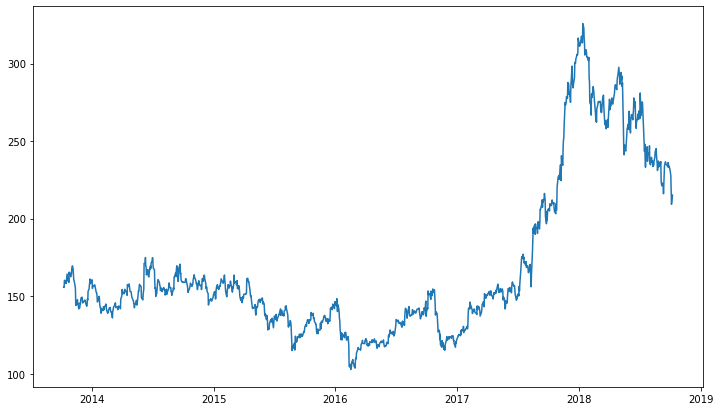

In [3]:
# Load dataset
df = pd.read_csv("NSE-Tata-Global-Beverages-Limited.csv")
df["Date"]=pd.to_datetime(df.Date,format="%Y-%m-%d")
display(df.head())
display(df.info())
# Dataviz
fig,ax1=plt.subplots()
ax1=plt.plot(df["Date"],df["Close"],label='Close Price history')

,Close
Date,
2013-10-08,155.8
2013-10-09,155.55
2013-10-10,160.15
2013-10-11,160.05
2013-10-12,NaN


(1827, 1)

,Close
Date,
2013-10-13,157.887500
2013-10-20,160.925000
2013-10-27,161.900000
2013-11-03,165.308333
2013-11-10,162.900000


(262, 1)

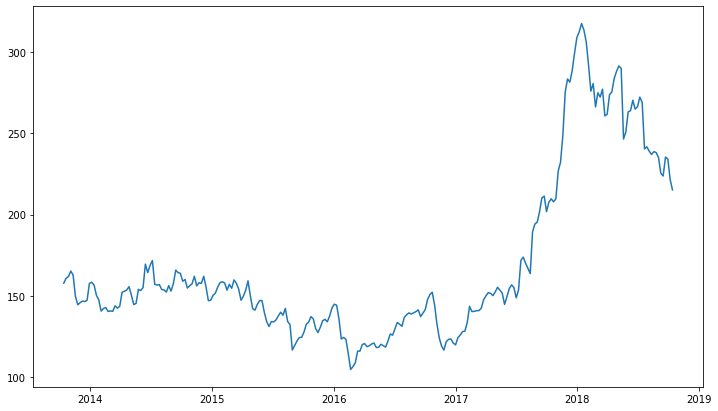

In [4]:
# Selecting the time series from the initial dataset, sorting in ascending order of date
df2=df.sort_values(by=["Date"],ascending=True,axis=0).reset_index(drop=True)
df3=pd.DataFrame(index=range(0,len(df2)),columns=['Date','Close'])
for i in range(0,len(df3)):
    df3["Date"][i]=df2['Date'][i]
    df3["Close"][i]=df2["Close"][i]   
df3.index=df3.Date
df3.drop("Date",axis=1,inplace=True)
# Handling missing values (missing dates... the time seres is not a time series...). Resampling
df3=df3.asfreq(freq='D') # This will add rows so that frequency is equal to 1 day. But this will generate NaNs
display(df3.head(), df3.shape)
# Resample Data to Weekly instead of Daily by Aggregating Using Mean
df3= df3.resample('W').mean()
display(df3.head(), df3.shape)
plt.plot(df3,label='Weekly Averages Stock')
plt.show()
# 'resample' method fills Nans values, unlike 'asfreq'. Otherwise we use the following to fill NaNs with interpolating
#https://towardsdatascience.com/4-techniques-to-handle-missing-values-in-time-series-data-c3568589b5a8
#df3=df3.astype('float')
#df3['Close'].interpolate(inplace=True,limit_direction='forward', axis=0) #default is linear interpolating
#display(df3.head(10))
#display(df3.shape)

<hr style="border-width:2px;border-color:#75DFC1">
<h2 style = "text-align:center"> Time Series analysis: stationnarity, autocorrelations, statistic tests </h2> 
<hr style="border-width:2px;border-color:#75DFC1">

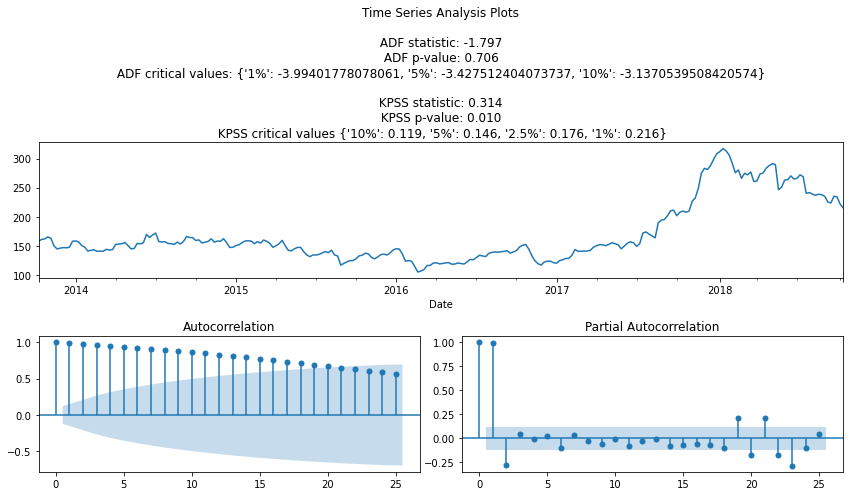

In [5]:
def tsplot(y, lags=None, figsize=(12, 7)):   
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))
    y.plot(ax=ts_ax)
    ADF_statistic, KPSS_statistic=sm.tsa.stattools.adfuller(y,regression='ct')[0], sm.tsa.stattools.kpss(y,regression='ct')[0]
    ADF_pvalue , KPSS_pvalue = sm.tsa.stattools.adfuller(y,regression='ct')[1], sm.tsa.stattools.kpss(y,regression='ct')[1]
    ADF_critvalues , KPSS_critvalues = sm.tsa.stattools.adfuller(y,regression='ct')[4], sm.tsa.stattools.kpss(y,regression='ct')[3]
    ts_ax.set_title('Time Series Analysis Plots\n \n ADF statistic: {0:.3f} \n ADF p-value: {1:.3f} \n ADF critical values: {2:} \n \n KPSS statistic: {3:.3f} \n KPSS p-value: {4:.3f} \n KPSS critical values {5:}'.format(ADF_statistic,ADF_pvalue,ADF_critvalues,KPSS_statistic,KPSS_pvalue,KPSS_critvalues))
    #ts_ax.set_title('Time Series Analysis Plots\n \n ADF p-value: {0:.3f} \n ADF critical values: {1:} \n \n KPSS p-value: {2:.3f} \n KPSS critical values {3:}'.format(ADF_pvalue,ADF_critvalues,KPSS_pvalue,KPSS_critvalues))
    sm.graphics.tsa.plot_acf(y, lags=lags, ax=acf_ax)
    sm.graphics.tsa.plot_pacf(y, lags=lags, ax=pacf_ax)
    plt.tight_layout()
# Plot the series
warnings.filterwarnings("ignore")
tsplot(df3['Close'])

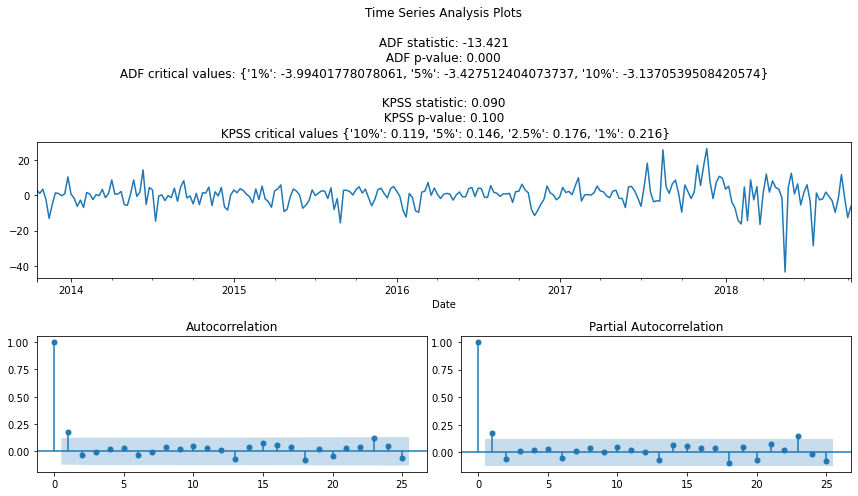

In [6]:
# Plot the series (differenced order 1)
ts_diff = df3["Close"].diff(1).dropna() 
warnings.filterwarnings("ignore")
tsplot(ts_diff)

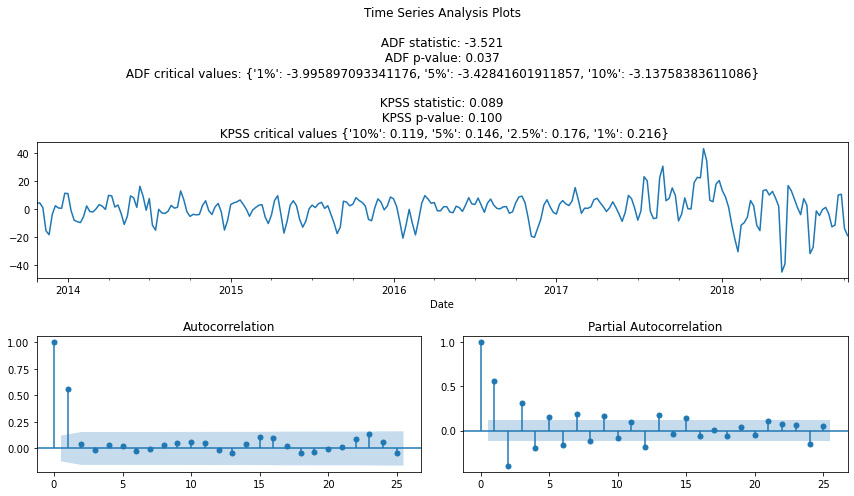

In [7]:
# Plot the series (differenced order 2)
ts_diff2 = df3["Close"].diff(2).dropna() 
warnings.filterwarnings("ignore")
tsplot(ts_diff2)



The statistic tests figure out if the time series is stationary around a constant or a constant and trend, or is non-stationary due to a unit root. We indeed  considered the two options regression='c' and regression='ct' that gave similar results.

The **null hypothesis** of the **Augmented Dickey-Fuller (ADF)** is that there is a unit root with the **alternative** that there is no unit root. If the p-value is above a critical size, then we cannot reject that there is a unit root and we shall consider the series not stationary.

The **null hypothesis** for the **Kwiatkowski–Phillips–Schmidt–Shin (KPSS)** test is that the data is stationary.
The **alternate hypothesis** for the test is that the data is not stationary.

https://www.machinelearningplus.com/time-series/augmented-dickey-fuller-test/

https://www.machinelearningplus.com/time-series/kpss-test-for-stationarity/#:~:text=KPSS%20test%20is%20a%20statistical,function%20and%20in%20practical%20usage.

The original time series is clearly not stationnary.

The differenced series (order 1) yields ADF p-value on the boundary limit: ADF p-value=0.000 for which I become skeptical. The KPSS p-value= 0.10 is also on the boundary limit. Both p-values indicate non stationnarity and autocorrelations , but I choose to look further and differenciate the series at the order 2.


<hr style="border-width:2px;border-color:#75DFC1">
<h2 style = "text-align:center"> ARIMA, Grid search walk-forward validation </h2> 
<hr style="border-width:2px;border-color:#75DFC1">

In [8]:
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.7)
    test_size = int(len(X) * 0.15)
    train, test ,forecast = X[0:train_size], X[train_size:train_size+test_size], X[train_size+test_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = sm.tsa.SARIMAX(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse,train,test,predictions,model_fit
 
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse,train,test,predictions,model_fit = evaluate_arima_model(dataset, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

# evaluate parameters
p_values = [0, 1, 2]
d_values = range(1, 2)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(df3.Close.values, p_values, d_values, q_values) #Pay attention to df.ColumnName.values

ARIMA(0, 1, 0) RMSE=8.936
ARIMA(0, 1, 1) RMSE=8.340
ARIMA(0, 1, 2) RMSE=8.372
ARIMA(1, 1, 0) RMSE=8.368
ARIMA(1, 1, 1) RMSE=8.353
ARIMA(2, 1, 0) RMSE=8.397
ARIMA(2, 1, 1) RMSE=8.645
ARIMA(2, 1, 2) RMSE=8.742
Best ARIMA(0, 1, 1) RMSE=8.340


In [9]:
train_size = int(len(df3.Close.values) * 0.7)
test_size = int(len(df3.Close.values) * 0.15)
X=df3.Close.values
X_train,X_test ,X_forecast = X[0:train_size], X[train_size:train_size+test_size], X[train_size+test_size:]

Best RMSE: 7.948


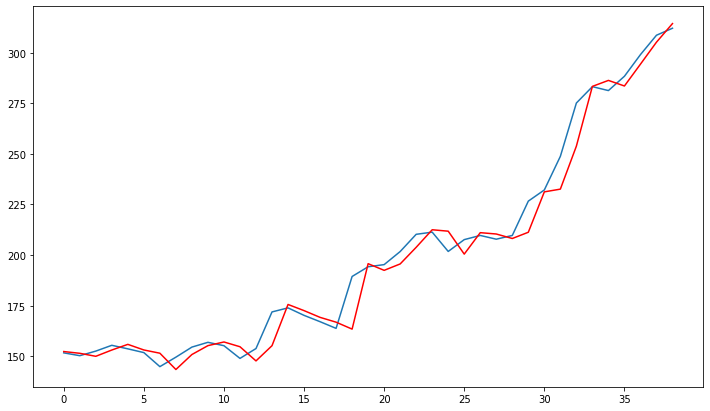

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  221
Model:               SARIMAX(2, 2, 1)   Log Likelihood                -674.992
Date:                Wed, 31 Aug 2022   AIC                           1357.983
Time:                        13:43:36   BIC                           1371.539
Sample:                             0   HQIC                          1363.458
                                - 221                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2165      0.072      3.005      0.003       0.075       0.358
ar.L2         -0.1326      0.075     -1.769      0.077      -0.280       0.014
ma.L1         -0.9417      0.035    -27.076      0.000      -1.010      -0.873
sigma2        27.5772      1.737     15.879      0.000      24.173      30.981
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):               107.30
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               1.57   Skew:                             0.50
Prob(H) (two-sided):                  0.06   Kurtosis:                         6.28
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

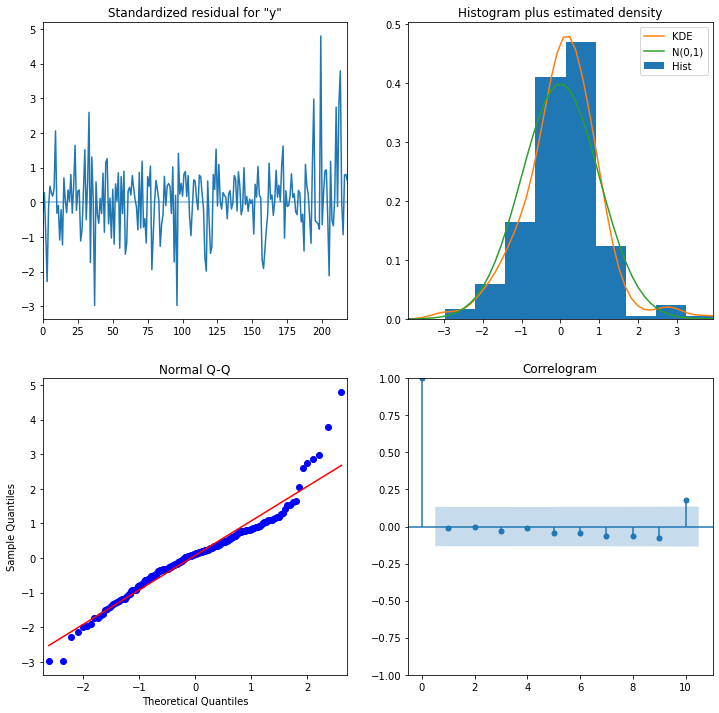

In [10]:
# Evaluate with best parameters
rmse,train,test,predictions,model_fit = evaluate_arima_model(df3.Close.values, (2, 2, 1)) #Pay attention to df.ColumnName.values
print('Best RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()
display(model_fit.summary())
##Checking Model Diagnotics on Training Data
model_fit.plot_diagnostics(figsize=(12, 12))
plt.show()

In [11]:
residuals = model_fit.resid
sm.stats.diagnostic.het_arch(residuals, nlags=None, store=False, ddof=0)

(22.969459194532845,
 0.08479045649414879,
 1.5896062036989769,
 0.07962508013381792)

Best RMSE: 8.055


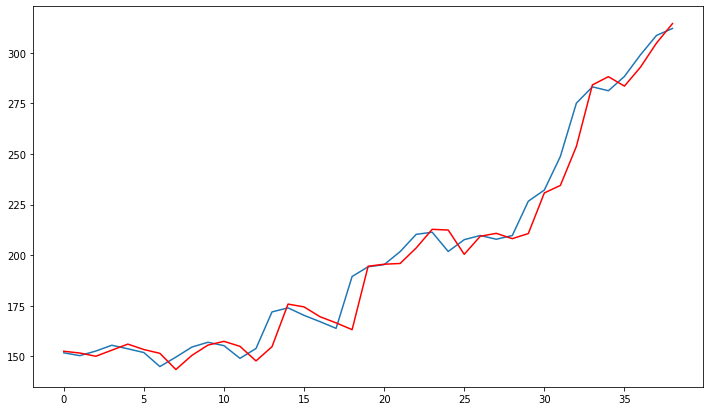

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  221
Model:               SARIMAX(1, 2, 1)   Log Likelihood                -676.782
Date:                Wed, 31 Aug 2022   AIC                           1359.564
Time:                        13:43:40   BIC                           1369.731
Sample:                             0   HQIC                          1363.670
                                - 221                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2048      0.073      2.801      0.005       0.062       0.348
ma.L1         -0.9546      0.029    -33.073      0.000      -1.011      -0.898
sigma2        28.0367      1.698     16.509      0.000      24.708      31.365
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):               115.20
Prob(Q):                              0.79   Prob(JB):                         0.00
Heteroskedasticity (H):               1.65   Skew:                             0.54
Prob(H) (two-sided):                  0.03   Kurtosis:                         6.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

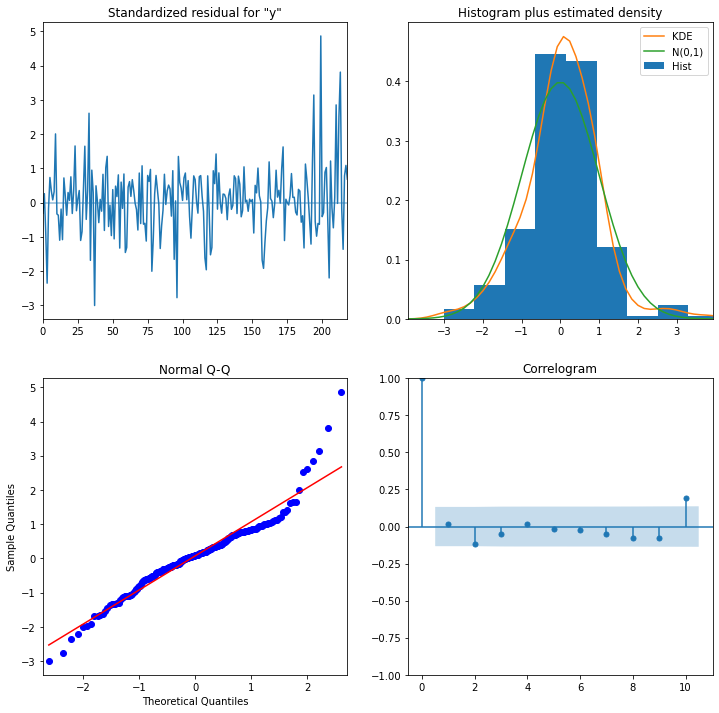

In [12]:
# Evaluate with other parameters
rmse,train,test,predictions,model_fit = evaluate_arima_model(df3.Close.values, (1, 2, 1)) #Pay attention to df.ColumnName.values
print('Best RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()
display(model_fit.summary())
##Checking Model Diagnotics on Training Data
model_fit.plot_diagnostics(figsize=(12, 12))
plt.show()

In [13]:
residuals = model_fit.resid
sm.stats.diagnostic.het_arch(residuals, nlags=None, store=False, ddof=0)

(26.337527710093813,
 0.03462111283552506,
 1.8568634844873935,
 0.02986489651398437)

Best RMSE: 8.340


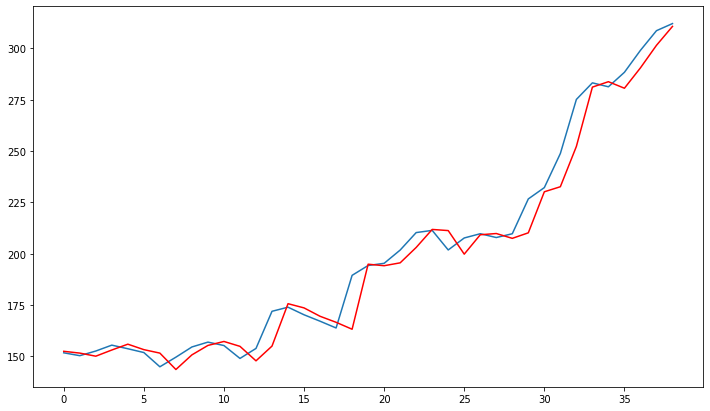

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  221
Model:               SARIMAX(0, 1, 1)   Log Likelihood                -680.847
Date:                Wed, 31 Aug 2022   AIC                           1365.695
Time:                        13:43:42   BIC                           1372.482
Sample:                             0   HQIC                          1368.436
                                - 221                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.2949      0.054      5.503      0.000       0.190       0.400
sigma2        28.5376      1.639     17.409      0.000      25.325      31.751
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               148.80
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               1.81   Skew:                             0.70
Prob(H) (two-sided):                  0.01   Kurtosis:                         6.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

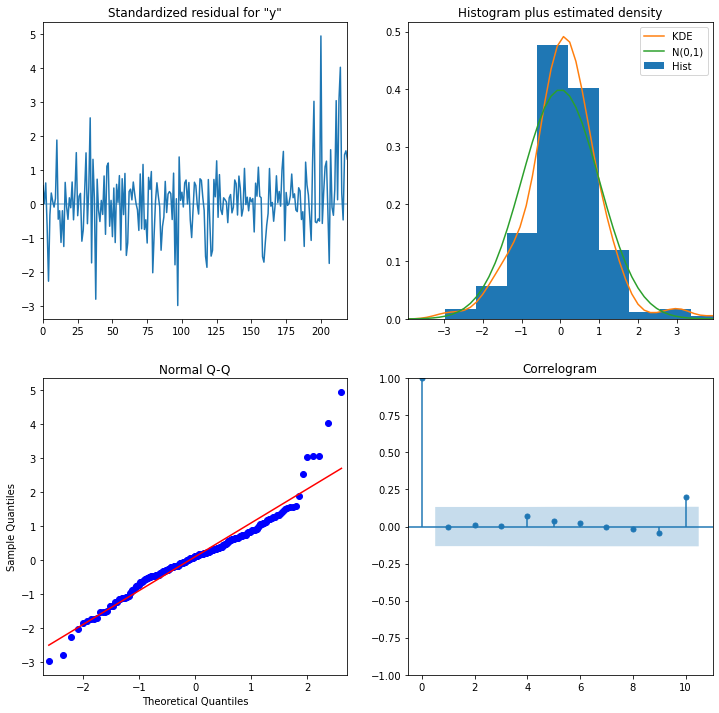

In [14]:
# Evaluate with best parameters
rmse,train,test,predictions,model_fit = evaluate_arima_model(df3.Close.values, (0, 1, 1)) #Pay attention to df.ColumnName.values
print('Best RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()
display(model_fit.summary())
##Checking Model Diagnotics on Training Data
model_fit.plot_diagnostics(figsize=(12, 12))
plt.show()

In [15]:
arima_residuals = model_fit.resid
sm.stats.diagnostic.het_arch(arima_residuals, nlags=None, store=False, ddof=0)

(44.35383928774254,
 9.677856346058067e-05,
 3.4755870177752817,
 2.9480984703127237e-05)

In [18]:

# fit a GARCH(1,1) model on the residuals of the ARIMA model
garch = arch.arch_model(arima_residuals, p=1, q=1)
garch_fitted = garch.fit()

# Use ARIMA to predict mu
predicted_mu = model_fit.predict(n_periods=1)[0]
# Use GARCH to predict the residual
garch_forecast = garch.forecast(horizon=1)
predicted_et = garch_forecast.mean['h.1'].iloc[-1]
# Combine both models' output: yt = mu + et
prediction = predicted_mu + predicted_et

Iteration:      1,   Func. Count:      6,   Neg. LLF: 259506896.56634885
Iteration:      2,   Func. Count:     12,   Neg. LLF: 812.4172940554929
Iteration:      3,   Func. Count:     18,   Neg. LLF: 904.4402970449579
Iteration:      4,   Func. Count:     25,   Neg. LLF: 702.8140085428837
Iteration:      5,   Func. Count:     31,   Neg. LLF: 697.9341699209872
Iteration:      6,   Func. Count:     36,   Neg. LLF: 697.9330567318308
Iteration:      7,   Func. Count:     41,   Neg. LLF: 697.932698342893
Iteration:      8,   Func. Count:     46,   Neg. LLF: 697.9326934554003
Iteration:      9,   Func. Count:     51,   Neg. LLF: 697.9326922403991
Iteration:     10,   Func. Count:     55,   Neg. LLF: 697.9326922403902
Optimization terminated successfully    (Exit mode 0)
            Current function value: 697.9326922403991
            Iterations: 10
            Function evaluations: 55
            Gradient evaluations: 10


TypeError: forecast() missing 1 required positional argument: 'params'

ARCH Lagrange Multiplier (ARCH-LM) test is a test used to test for ARCH effects by regressing the squared errors on its lags. The null hypothesis is that the lagged regression coefficients are zero there are no ARCH effects.


https://medium.com/analytics-vidhya/arima-garch-forecasting-with-python-7a3f797de3ff

<hr style="border-width:2px;border-color:#75DFC1">
<h2 style = "text-align:center"> LSTM Neural Network </h2> 
<hr style="border-width:2px;border-color:#75DFC1">

In [ ]:
# Preparing data for LSTM
# Convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# Selecting the time series from the initial dataframe --> called 'values' (np.array)
values=df3.values
display(values.shape)
## integer encode direction
##encoder = LabelEncoder()
##values[:,4] = encoder.fit_transform(values[:,4])

# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# specify the number of lag hours
n_weeks = 8
n_features = 1
# frame as supervised learning
reframed = series_to_supervised(scaled, n_weeks, 1)
print(reframed.head())
print(reframed.shape)

# split into train and test sets
values = reframed.values
n_train_weeks = int(len(values) * 0.7)
n_test_weeks = int(len(values) * 0.15)
train = values[:n_train_weeks, :]
test = values[n_train_weeks:n_train_weeks+n_test_weeks, :]
forecast = values[n_train_weeks+n_test_weeks:, :]
# split into input and outputs
n_obs = n_weeks * n_features
X_train, y_train = train[:, :n_obs], train[:, -n_features]
X_test, y_test = test[:, :n_obs], test[:, -n_features]
X_forecast, y_forecast = forecast[:, :n_obs], forecast[:, -n_features]
print(X_train.shape, len(X_train), y_train.shape)
# reshape input to be 3D [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], n_weeks, n_features))
X_test = X_test.reshape((X_test.shape[0], n_weeks, n_features))
X_forecast = X_forecast.reshape((X_forecast.shape[0], n_weeks, n_features))
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape,X_forecast.shape,y_forecast.shape)

In [ ]:
# Model : LSTM(50),Dense(1)
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(X_train, y_train, epochs=180, batch_size=20, validation_data=(X_test, y_test), verbose=1, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [ ]:
# Make a prediction for validation and forecasting
yhat_test = model.predict(X_test)
X_test2 = X_test.reshape((X_test.shape[0], X_test.shape[1]))
yhat_forecast = model.predict(X_forecast)
X_forecast2 = X_forecast.reshape((X_forecast.shape[0], X_forecast.shape[1]))
# invert scaling 
inv_yhat_test = concatenate((yhat_test, X_test2[:, - n_features -1:]), axis=1)
inv_yhat_test = scaler.inverse_transform(inv_yhat_test)
inv_yhat_test = inv_yhat_test[:,0]
inv_yhat_forecast = concatenate((yhat_forecast, X_forecast2[:, - n_features -1:]), axis=1)
inv_yhat_forecast = scaler.inverse_transform(inv_yhat_forecast)
inv_yhat_forecast = inv_yhat_forecast[:,0]
# invert scaling for actual
y_test = y_test.reshape((len(y_test), 1))
inv_y_test = concatenate((y_test, X_test2[:, - n_features -1:]), axis=1)
inv_y_test = scaler.inverse_transform(inv_y_test)
inv_y_test = inv_y_test[:,0]
y_forecast = y_forecast.reshape((len(y_forecast), 1))
inv_y_forecast = concatenate((y_forecast, X_forecast2[:, - n_features -1:]), axis=1)
inv_y_forecast = scaler.inverse_transform(inv_y_forecast)
inv_y_forecast = inv_y_forecast[:,0]

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y_test, inv_yhat_test))
print('Test RMSE: %.3f' % rmse)
rmse = sqrt(mean_squared_error(inv_y_forecast, inv_yhat_forecast))
print('Forecast RMSE: %.3f' % rmse)
# Plot prediction
df_values=df3.Close
d = {'train': df_values,
     'test': pd.Series(inv_yhat_test, index=df_values.index[np.arange(n_train_weeks+n_weeks,n_train_weeks+n_test_weeks+n_weeks)]),
     'forecast': pd.Series(inv_yhat_forecast, index=df_values.index[np.arange(n_train_weeks+n_test_weeks+n_weeks,len(values)+n_weeks)])
                           }
df_plot=pd.DataFrame(data=d, index=df3.index)
plt.figure();
plt.plot(df_plot);


In [ ]:
# Mode2 : LSTM(50),LSTM(50),Dense(1)
# design network
model2 = Sequential()
model2.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model2.add(Dense(1))
model2.compile(loss='mae', optimizer='adam')
# fit network
history2 = model2.fit(X_train, y_train, epochs=180, batch_size=20, validation_data=(X_test, y_test), verbose=1, shuffle=False)
# plot history
plt.plot(history2.history['loss'], label='train')
plt.plot(history2.history['val_loss'], label='test')
plt.legend()
plt.show()